In [1]:
import os
import re

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tqdm import tqdm_notebook
from tensorflow.keras import backend as K

In [2]:
posts_df = pd.read_json('data/stackoverflow/sample/CombinedDocs.100K.Questions.jsonl.gz', lines=True)
print('Original posts: {:,}'.format(len(posts_df.index)))
posts_df.head(5)

Original posts: 273,876


,Comments,_AcceptedAnswerId,_AnswerCount,_Body,_ClosedDate,_CommentCount,_CommunityOwnedDate,_CreationDate,_FavoriteCount,_Id,...,_Owner,_OwnerDisplayName,_OwnerUserId,_ParentId,_PostTypeId,_Score,_Tags,_Title,_ViewCount,_Votes
0,"[{'_CreationDate': '2013-02-20T21:15:11.130', ...",NaN,NaN,"<p>What event do you want to use as trigger, t...",None,7,None,2013-02-20T21:15:11.130,NaN,14990058,...,{'_AboutMe': '<ul> <li>ASP.NET and Windows-Dev...,None,284240,14989981.0,2,2,None,None,NaN,"[{'_BountyAmount': None, '_CreationDate': '201..."
1,"[{'_CreationDate': '2015-09-14T22:02:20.670', ...",NaN,NaN,"<p>When the build/publish script ran, the wron...",None,0,None,2015-09-14T22:02:20.670,NaN,32574652,...,{'_AboutMe': '<p>Keith lives in SE Florida and...,None,86555,32569215.0,2,0,None,None,NaN,"[{'_BountyAmount': None, '_CreationDate': '201..."
2,"[{'_CreationDate': '2012-06-12T14:02:37.243', ...",NaN,NaN,<p>In the interface add the method declaration...,None,3,None,2012-06-12T14:02:37.243,NaN,10998316,...,"{'_AboutMe': '<h1>SOreadytohelp</h1> ', '_Acco...",None,693272,10998270.0,2,3,None,None,NaN,"[{'_BountyAmount': None, '_CreationDate': '201..."
3,"[{'_CreationDate': '2014-07-30T13:14:15.723', ...",NaN,NaN,<p>Every answer so far is correct and points o...,None,0,None,2014-07-30T13:14:15.723,NaN,25037786,...,{'_AboutMe': '<p>Expertise with</p> <ul> <li>...,None,1649198,25037558.0,2,0,None,None,NaN,None
4,"[{'_CreationDate': '2009-08-19T20:18:55.647', ...",NaN,1.0,<p>This is what i have.</p>\n\n<pre><code>$num...,None,0,None,2009-08-19T20:18:55.647,NaN,1302404,...,None,None,115949,NaN,1,0,<php>,Break apart variable contents and load into ar...,337.0,None


In [3]:
tag_posts = posts_df.dropna(axis=0, subset=['_Tags'])
print('Posts w/ tags: {:,}'.format(len(tag_posts.index)))
tag_posts.head(5)

Posts w/ tags: 98,278


,Comments,_AcceptedAnswerId,_AnswerCount,_Body,_ClosedDate,_CommentCount,_CommunityOwnedDate,_CreationDate,_FavoriteCount,_Id,...,_Owner,_OwnerDisplayName,_OwnerUserId,_ParentId,_PostTypeId,_Score,_Tags,_Title,_ViewCount,_Votes
4,"[{'_CreationDate': '2009-08-19T20:18:55.647', ...",NaN,1.0,<p>This is what i have.</p>\n\n<pre><code>$num...,None,0,None,2009-08-19T20:18:55.647,NaN,1302404,...,None,None,115949,NaN,1,0,<php>,Break apart variable contents and load into ar...,337.0,None
6,"[{'_CreationDate': '2015-02-02T23:17:47.047', ...",NaN,1.0,<p>Hi this script shows a Google's map in Palo...,None,8,None,2015-02-02T23:17:47.047,NaN,28288660,...,None,None,4472264,NaN,1,1,<javascript><wordpress><google-maps><google-ma...,Google Map API v3 not working in Wordpress,503.0,"[{'_BountyAmount': None, '_CreationDate': '201..."
8,"[{'_CreationDate': '2019-01-23T15:37:18.230', ...",NaN,1.0,<p>I'm creating an app (personal project) that...,None,2,None,2019-01-23T15:37:18.230,NaN,54330748,...,None,None,2913976,NaN,1,1,<ruby-on-rails><ruby><ruby-on-rails-4><activer...,Trying to collect a list of ids from checkboxe...,37.0,"[{'_BountyAmount': None, '_CreationDate': '201..."
15,"[{'_CreationDate': '2014-11-16T09:15:33.277', ...",26955818.0,2.0,<p>I want to change item color and it's parent...,None,0,None,2014-11-16T09:15:33.277,NaN,26955440,...,None,None,3839473,NaN,1,1,<javascript><jquery><html><css>,change font color when clicking on menu with j...,872.0,"[{'_BountyAmount': None, '_CreationDate': '201..."
19,"[{'_CreationDate': '2008-09-30T15:00:01.233', ...",155597.0,3.0,<p>I have a VB6 COM component which I need to ...,None,0,None,2008-09-30T15:00:01.233,NaN,153438,...,"{'_AboutMe': '<p><a href=""http://www.leapinggo...",Wolfwyrd,15570,NaN,1,0,<c#><.net><com><interop>,Retrieving the original error number from a CO...,2120.0,None


In [4]:
tag_posts['_Tag_List'] = tag_posts['_Tags'].apply(lambda x: re.findall('\<(.+?)\>', x))

flat_tags = tag_posts.apply(lambda x: pd.Series(x['_Tag_List']),axis=1).stack().reset_index(level=1, drop=True)
flat_tags.head(5)

/home/rjurney/anaconda/envs/deep/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


4                  php
6           javascript
6            wordpress
6          google-maps
6    google-maps-api-3
dtype: object

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt

tag_counts = flat_tags.groupby(flat_tags).count().sort_values(ascending=False)
print(tag_counts[0:10])

javascript    10080
java           8792
c#             7374
php            7303
python         6470
android        6399
jquery         5471
html           4817
c++            3579
css            3397
dtype: int64


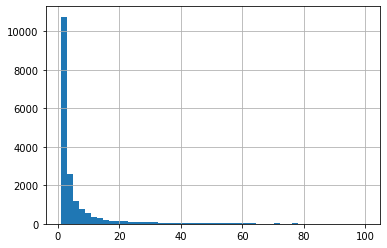

In [6]:
tag_counts[tag_counts <= 100].hist(bins=50)

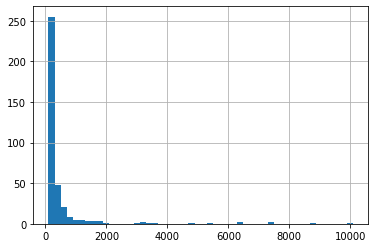

In [7]:
tag_counts[tag_counts > 100].hist(bins=50)

In [8]:
from collections import defaultdict
# import seaborn as sns

tag_counts = defaultdict(int)

for row in tag_posts['_Tag_List']:
    for tag in row:
        tag_counts[tag] += 1

for i in [0, 10, 20, 50, 100, 1000]:
    filtered_tags = list(filter(lambda x: x > i, tag_counts.values()))
    print('There are {:,} tags with more than {:,} count'.format(len(filtered_tags), i))

MIN_TAGS = 1000

record_count = len([i for i in filter(lambda x: x > MIN_TAGS, tag_counts.values())])
record_count

There are 18,549 tags with more than 0 count
There are 2,730 tags with more than 10 count
There are 1,589 tags with more than 20 count
There are 709 tags with more than 50 count
There are 367 tags with more than 100 count
There are 33 tags with more than 1,000 count


33

In [9]:
all_tags = set()
for row in tag_posts['_Tag_List']:
    for tag in row:
        if tag_counts[tag] > MIN_TAGS:
            all_tags.add(tag)
print('Total unique tags with {:,} occurrences: {:,}'.format(MIN_TAGS, len(all_tags)))
sorted_all_tags = sorted(all_tags)

tag_to_id = {val:i for i, val in enumerate(sorted_all_tags)}
id_to_tag = {i:val for i, val in enumerate(sorted_all_tags)}

Total unique tags with 1,000 occurrences: 33


In [10]:
labels = []
tag_list = tag_posts['_Tag_List'].tolist()

# Loop through every post...
for i, tag_set in enumerate(tag_posts['_Tag_List'].tolist()):
    # Then build a record_count element wide list for each tag present
    label_row = []
    for tag in sorted_all_tags:
        if tag in tag_list[i]:
            label_row.append(1)
        else:
            label_row.append(0)
    labels.append(label_row)
    
tag_labels = [id_to_tag[key_id] for key_id in sorted(id_to_tag.keys()) if tag_counts[id_to_tag[key_id]] > MIN_TAGS]

len(labels), len(labels[0]), len(tag_labels)

(98278, 33, 33)

In [11]:
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer


def extract_text(x):
    """Extract non-code text from posts (questions/answers)"""
    doc = BeautifulSoup(x)
    codes = doc.find_all('code')
    [code.extract() if code else None for code in codes]
    return ' '.join(doc.text.split()[0:150])

post_text = tag_posts._Body.apply(extract_text)

t = Tokenizer(5000)
t.fit_on_texts(post_text)
tokenized_text = t.texts_to_matrix(post_text)
tokenized_text

Using TensorFlow backend.


array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [12]:
tokenized_text.shape, len(labels), len(labels[0])

((98278, 5000), 98278, 33)

In [13]:
# Validate the posts match the labels
assert(tokenized_text.shape[0] == len(labels))
print('We are left with {:,} example posts'.format(tokenized_text.shape[0]))

We are left with 98,278 example posts


In [14]:
TRAINING_COUNT = 10000

# Filter rows with all 0s for tags
label_mx = np.array(labels)
del labels
max_per_row = label_mx.max(axis=1)
non_zero_index = np.nonzero(max_per_row)

label_mx = label_mx[non_zero_index][0:TRAINING_COUNT]
tokenized_text = tokenized_text[non_zero_index]
tokenized_text = tokenized_text[0:TRAINING_COUNT]

tokenized_text.shape, label_mx.shape

((10000, 5000), (10000, 33))

In [15]:
token_lengths = [len(x) for x in tokenized_text.tolist()]

In [15]:
from sklearn.model_selection import train_test_split

TEST_SPLIT = 0.1

X_train, X_test, y_train, y_test = train_test_split(
    tokenized_text,
    label_mx,
    test_size=TEST_SPLIT,
    random_state=34
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9000, 5000), (1000, 5000), (9000, 33), (1000, 33))

In [23]:
from keras.layers import Input, concatenate, Activation, Dense, LSTM, BatchNormalization, Embedding, Dropout
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from keras.models import Model
from keras.optimizers import Adam
from keras_metrics import precision

MAX_TEXT_NB_WORDS = 5000
TEXT_EMBEDDING_DIM = 32

# Text model
text_input = Input(shape=(X_train.shape[1],))

text_embedding = Embedding(
    MAX_TEXT_NB_WORDS, 
    TEXT_EMBEDDING_DIM, 
    input_length=X_train.shape[1],
)(text_input)

text_lstm = LSTM(
    50, 
    input_shape=(X_train.shape[1], X_train.shape[1] * TEXT_EMBEDDING_DIM)
)(text_embedding)

text_dense = Dense(record_count, activation='sigmoid')(text_lstm)

text_batch = BatchNormalization()(text_dense)

text_model = Model(
    inputs=text_input, 
    outputs=text_batch
)

def abs_KL_div(y_true, y_pred):
    y_true = K.clip(y_true, K.epsilon(), None)
    y_pred = K.clip(y_pred, K.epsilon(), None)
    return K.sum(K.abs( (y_true - y_pred) * (K.log(y_true / y_pred))), axis=-1)

from keras.optimizers import Adam
adam = Adam(lr=0.001)

text_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[precision(), abs_KL_div, 'mae'])

text_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 5000)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 5000, 32)          160000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dense_3 (Dense)              (None, 33)                1683      
_________________________________________________________________
batch_normalization_3 (Batch (None, 33)                132       
Total params: 178,415
Trainable params: 178,349
Non-trainable params: 66
_________________________________________________________________


In [36]:
class_freq = np.sum(label_mx, axis=0) / label_mx.shape[0]
class_weights = (1 / class_freq).tolist()
class_weights_dict = {i:val for i, val in enumerate(class_weights)}

In [38]:
from sklearn.utils.class_weight import compute_sample_weight
from keras.callbacks import EarlyStopping

epochs = 4
batch_size = 32

history = text_model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[
        EarlyStopping(monitor='loss', patience=1, min_delta=0.001),
        EarlyStopping(monitor='val_loss', patience=1, min_delta=0.001),
    ],
    class_weight=class_weights_dict,
    validation_data=(X_test, y_test)
)

Train on 9000 samples, validate on 1000 samples
Epoch 1/4
9000/9000 [==============================] - 1079s 120ms/step - loss: 10.9362 - precision: 0.0000e+00 - abs_KL_div: 14.9345 - mean_absolute_error: 0.0546 - val_loss: 0.3935 - val_precision: 0.0000e+00 - val_abs_KL_div: 86.0637 - val_mean_absolute_error: 0.2190
Epoch 2/4
9000/9000 [==============================] - 1081s 120ms/step - loss: 10.3175 - precision: 0.0000e+00 - abs_KL_div: 16.1010 - mean_absolute_error: 0.0666 - val_loss: 0.4539 - val_precision: 0.0000e+00 - val_abs_KL_div: 69.5166 - val_mean_absolute_error: 0.1939


In [39]:
accr = text_model.evaluate(X_test, y_test)#, sample_weight=sample_weights)
[i for i in zip(accr, text_model.metrics_names)]

1000/1000 [==============================] - 32s 32ms/step


[(0.45392896127700805, 'loss'),
 (0.0, 'precision'),
 (69.51664611816406, 'abs_KL_div'),
 (0.19392103934288024, 'mean_absolute_error')]

{'val_loss': [0.39347290563583376, 0.45392896127700805], 'val_precision': [0.0, 0.0], 'val_abs_KL_div': [86.06371472167969, 69.51664611816406], 'val_mean_absolute_error': [0.21895033693313598, 0.19392103934288024], 'loss': [10.936246105617947, 10.317541198730469], 'precision': [0.0, -0.0], 'abs_KL_div': [14.934465355767145, 16.10102809990777], 'mean_absolute_error': [0.054640831351280214, 0.0665559841129515]}


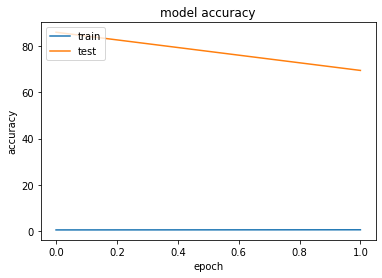

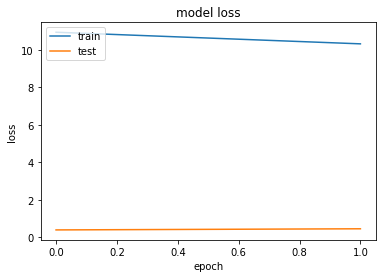

In [40]:
%matplotlib inline

import matplotlib.pyplot as plt

print(history.history)
# summarize history for accuracy
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_abs_KL_div'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
from sklearn.metrics import hamming_loss, jaccard_score

import keras.backend as K
import tensorflow as tf

y_pred = text_model.predict(X_test)

sess = tf.Session()
with sess.as_default():
    for cutoff in [0.0001, 0.001, 0.01, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8]:
        y_pred_bin = K.greater(y_pred, cutoff).eval()
        print('Cutoff: {:,}'.format(cutoff))
        print('Hamming loss: {:,}'.format(
            hamming_loss(y_test, y_pred_bin)
        ))
        for j_type in ['micro', 'macro', 'weighted']:
            print('Jaccard {} score: {:,}'.format(
                j_type,
                jaccard_score(y_test, y_pred_bin, average=j_type)
            ))
        print('')

Cutoff: 0.0001
Hamming loss: 0.6827878787878788
Jaccard micro score: 0.03697055178014275
Jaccard macro score: 0.026382129500260348
Jaccard weighted score: 0.04497032859273203
Cutoff: 0.001
Hamming loss: 0.6827575757575758
Jaccard micro score: 0.03697213198837408
Jaccard macro score: 0.026383624128659296
Jaccard weighted score: 0.044972022077269885
Cutoff: 0.01
Hamming loss: 0.626969696969697
Jaccard micro score: 0.037092195280867504
Jaccard macro score: 0.024297907519231013
Jaccard weighted score: 0.04298342135485958
Cutoff: 0.1
Hamming loss: 0.4511818181818182
Jaccard micro score: 0.04484218629715166
Jaccard macro score: 0.021331565184648335
Jaccard weighted score: 0.041689444527409115
Cutoff: 0.2
Hamming loss: 0.307
Jaccard micro score: 0.05503217983397071
Jaccard macro score: 0.018022252170713047
Jaccard weighted score: 0.03994746830711786
Cutoff: 0.4
Hamming loss: 0.06506060606060605
Jaccard micro score: 0.05418502202643172
Jaccard macro score: 0.0037573313782991204
Jaccard weighte

In [42]:
y_pred

array([[0.12111855, 0.36354065, 0.37200546, ..., 0.14501858, 0.04779339,
        0.1223917 ],
       [0.12111855, 0.36354065, 0.37200546, ..., 0.14501858, 0.04779339,
        0.12239075],
       [0.12111855, 0.36354065, 0.37200546, ..., 0.14501858, 0.04779339,
        0.1223917 ],
       ...,
       [0.12111855, 0.36354065, 0.37200546, ..., 0.14501858, 0.04779339,
        0.1223917 ],
       [0.12111855, 0.36354065, 0.37200546, ..., 0.14501858, 0.04779339,
        0.1223917 ],
       [0.12111855, 0.36354065, 0.37200546, ..., 0.14501858, 0.04779339,
        0.1223917 ]], dtype=float32)